# Prophet Model to Forecast Bus Demand

## Imports

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Reading Data

In [2]:
df = pd.read_csv("data/preprocessed_data.csv", engine="c")

## Visualize

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
fig = go.Figure()
for key, data in df.groupby('municipality_id'):
    fig.add_scatter(x=data.timestamp, y=data.usage, name=key, mode='lines')

iplot(fig)

## Utils

In [4]:
def evaluate_forecast(y_test, yhat):
    """
    Evaluation metrics with tensorflow
    :param y_test: real target values of test values
    :param yhat: predicted target values from test values
    :return: evaluation scores
    """
    mae = mean_absolute_error(y_test,yhat)
    print('mae:', mae)
    mse = mean_squared_error(y_test,yhat)
    print('mse:', mse)
    mape = mean_absolute_percentage_error(y_test,yhat)
    print('mape:', mape)

### Prepare Data to Prophet

In [5]:
df = df.rename(columns={"timestamp": "ds", "usage": "y"})

## Model

### Model Preparation

In [6]:
forecast_start = "2017-08-05 06"
forecast_end = "2017-08-19 16"
working_hours_start = 7
working_hours_end = 16

In [7]:
train_df = df.loc[df['date'] <= forecast_start]
test_df = df.loc[df['date'] > forecast_start]

In [8]:
test_df = test_df.pivot(index="ds", columns="municipality_id", values="y")
test_df.sort_index(axis=0)
test_df = test_df.fillna(0)
test_df = test_df.reset_index()

In [9]:
print(train_df.shape)
print(test_df.shape)

(6200, 7)
(150, 11)


### Create future dataframe to forecast

In [10]:
all_hours = pd.date_range(start=df.date.min(), end=df.date.max(), freq='H')
working_hours = [x for x in all_hours if (x.hour >= working_hours_start) & (x.hour <= working_hours_end)]
future = pd.DataFrame({'ds': working_hours})

### Train

In [11]:
grouped = train_df.groupby('municipality_id')
final = pd.DataFrame()
models = []
for g in grouped.groups:
    group = grouped.get_group(g)
    m = Prophet(yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality='auto',
            interval_width=0.95)
    m.fit(group)
    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'+ str(g), 'yhat_lower': 'yhat_lower_'+ str(g), 'yhat_upper': 'yhat_upper_'+ str(g)})
    final = pd.merge(final, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
    models.append(m)

22:26:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
22:26:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
22:26:32 - cmdstanpy - INFO - Chain [1] start processing
22:26:32 - cmdstanpy - INFO - Chain [1] done processing
22:26:33 - cmdstanpy - INFO - Chain [1] start processing
22:26:33 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_43573/3563622088.py:13: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'daily_upper_x', 'trend_x', 'multiplicative_terms_lower_x', 'additive_terms_lower_x', 'additive_terms_x', 'additive_terms_upper_x', 'daily_lower_x', 'weekly_x', 'trend_upper_x', 'trend_lower_x', 'weekly_lower_x', 'weekly_upper_x', 'multiplicative_terms_x', 'multiplicative_terms_upper_x', 'daily_x'} in the result is deprecated and will raise a MergeError in a future version.

22:26:33 - cmdstanpy - INFO - Chain [1] start processing
22:26:33

### Reduced dimension of forecast result

In [12]:
columns = []
for i in grouped.groups.keys():
    columns.append(f"yhat_{i}")
    columns.append(f"yhat_lower_{i}")
    columns.append(f"yhat_upper_{i}")
final = final[columns]

In [13]:
final = final.reset_index()

## Visualize

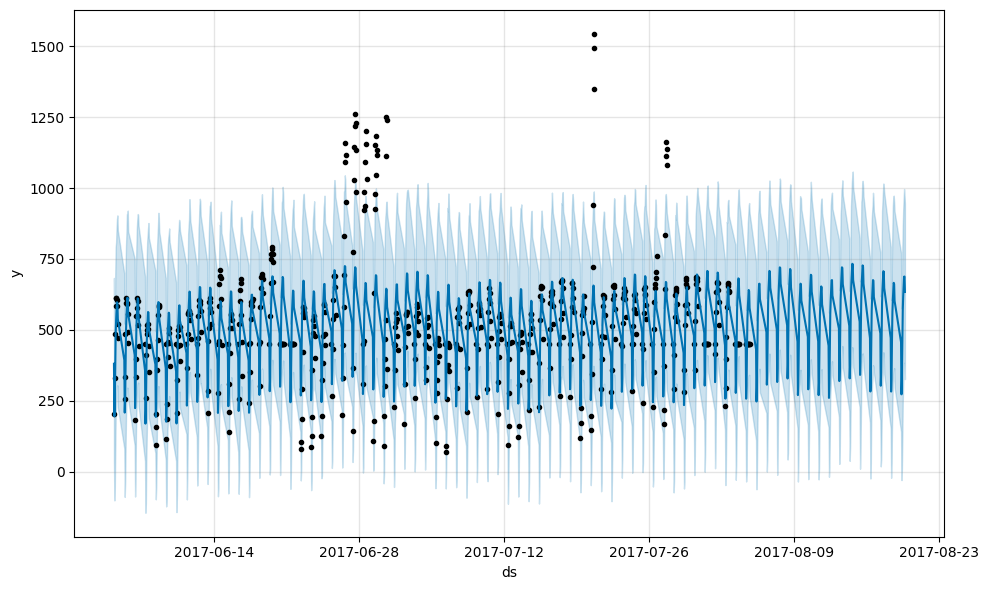

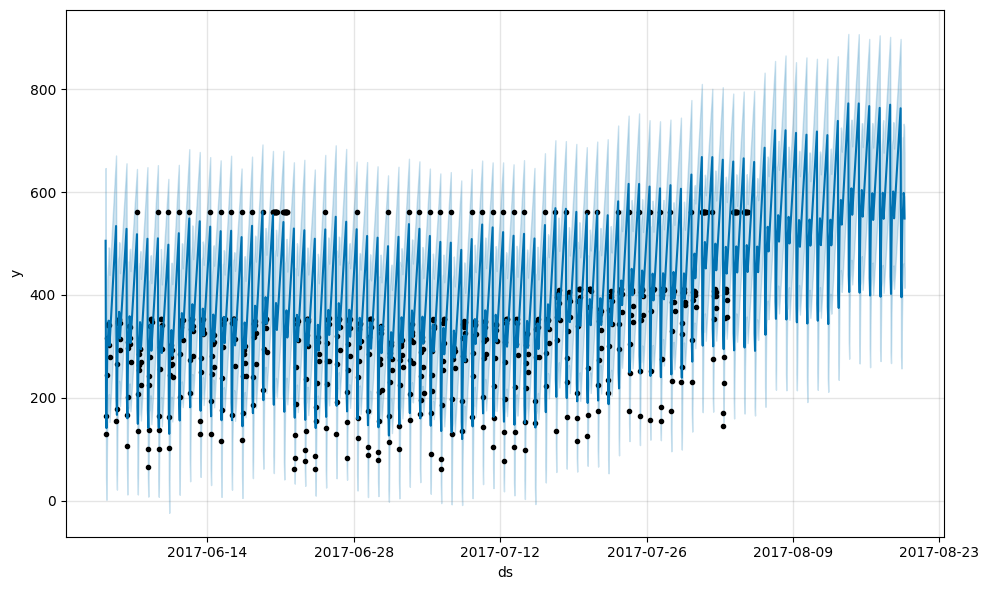

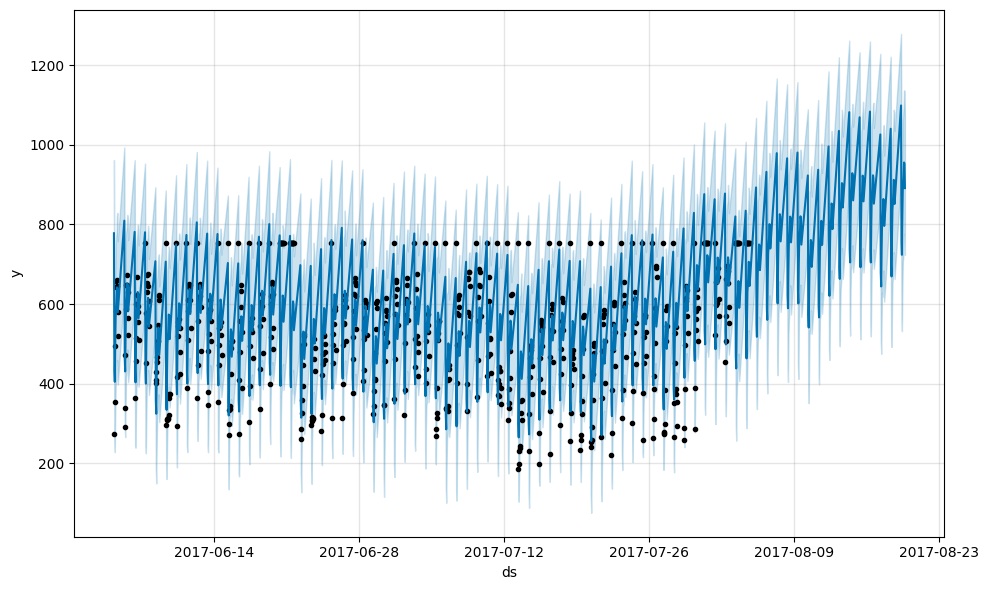

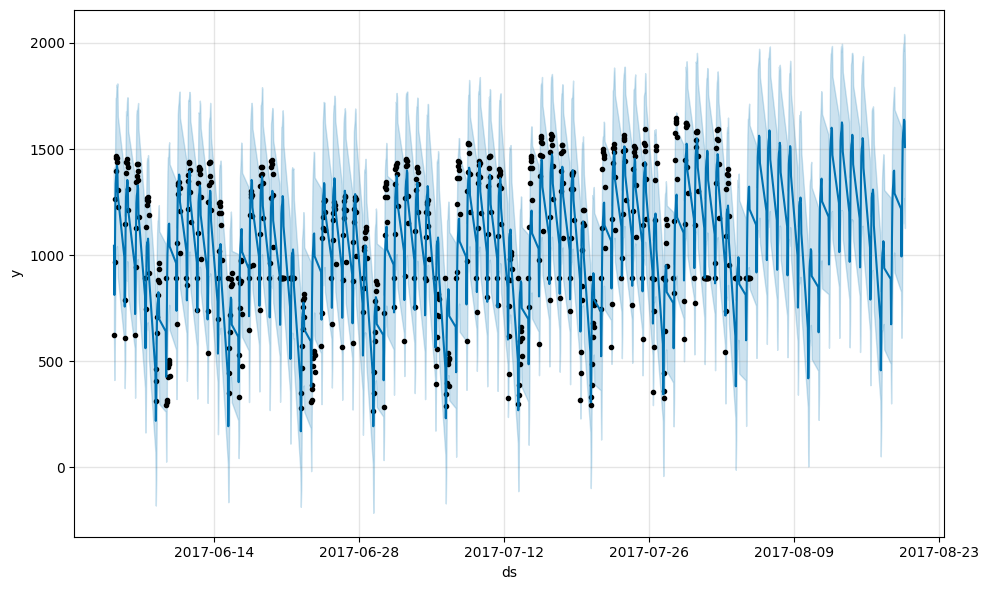

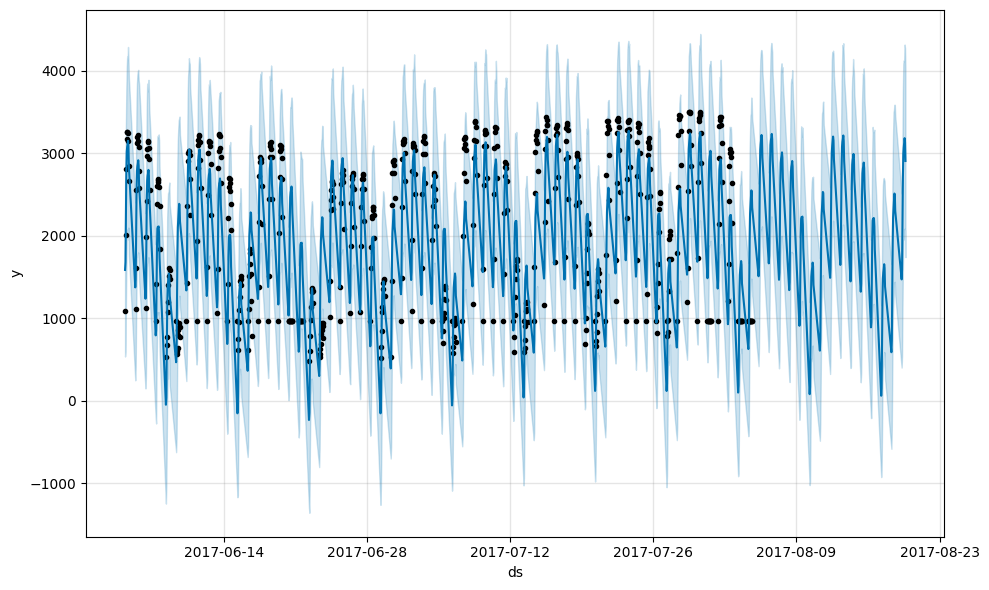

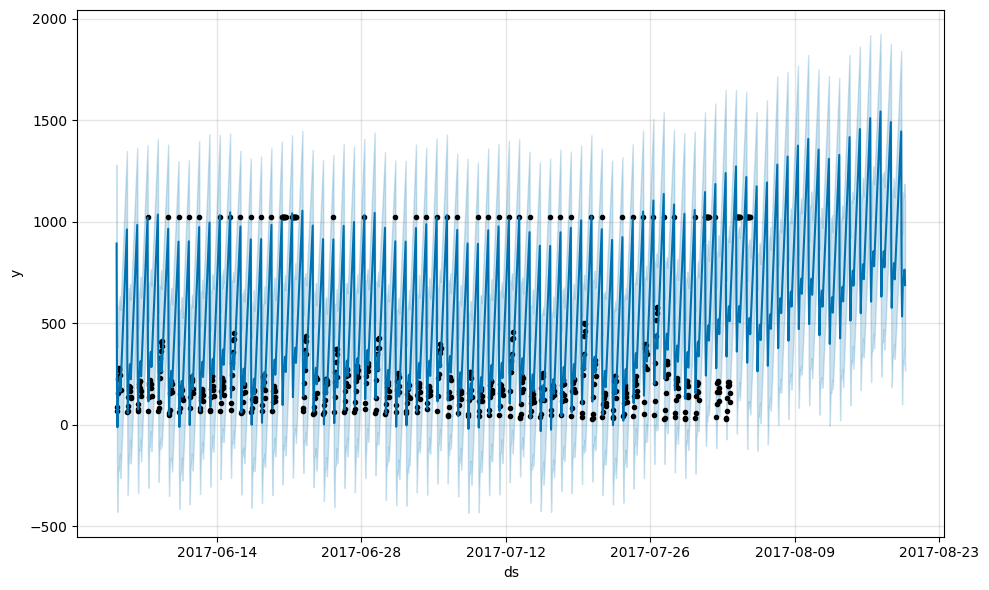

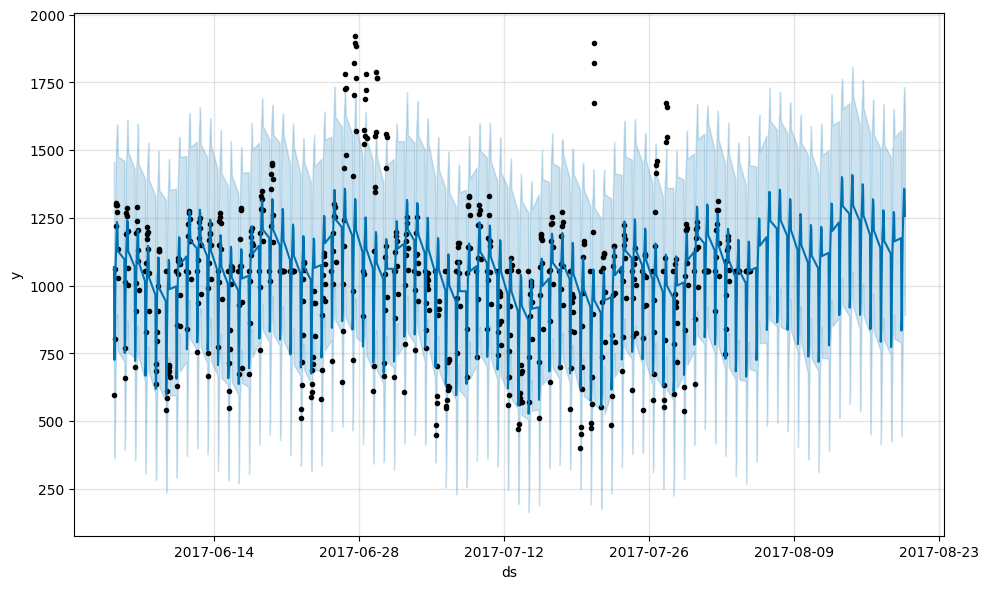

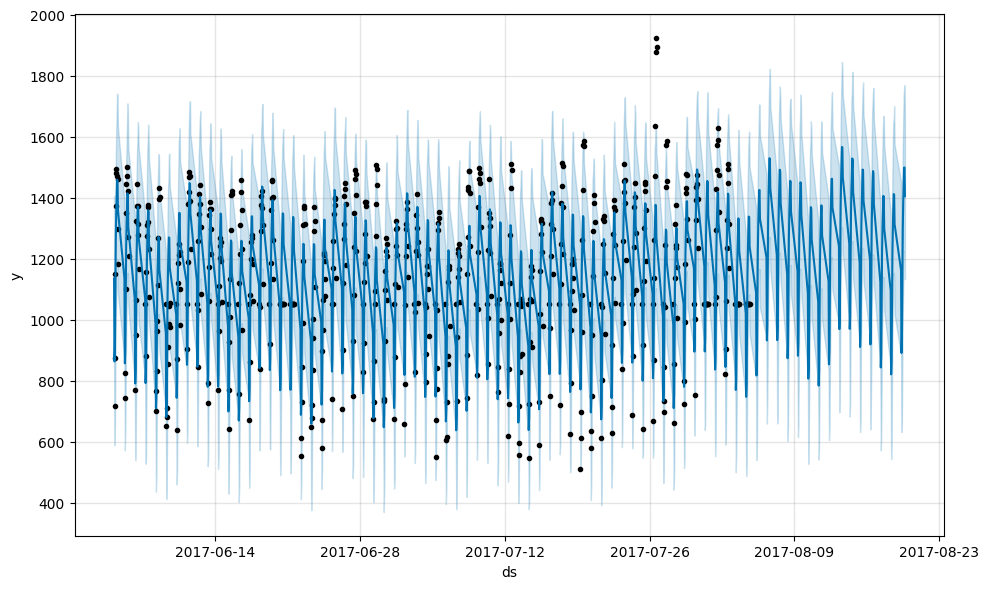

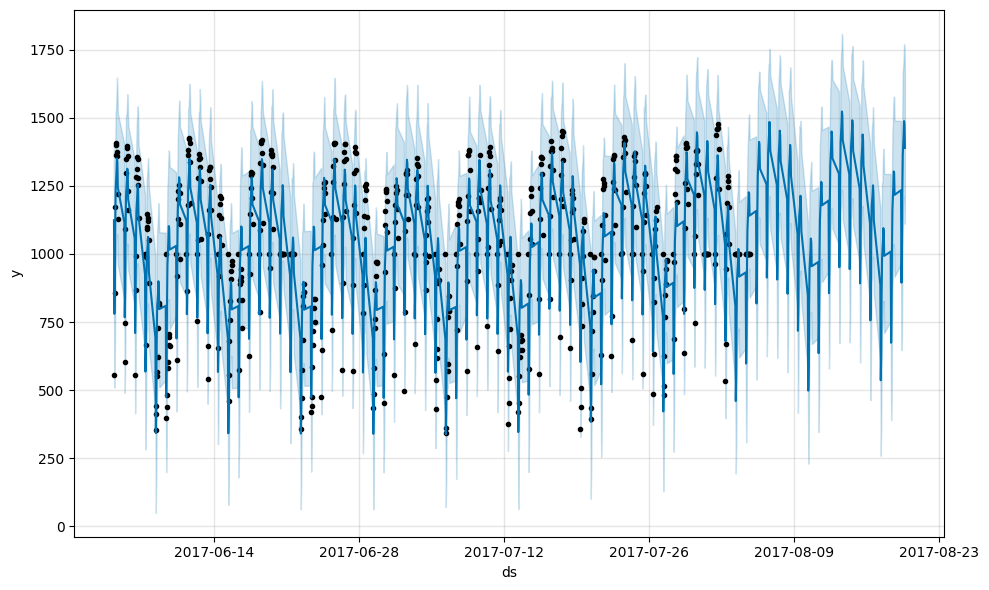

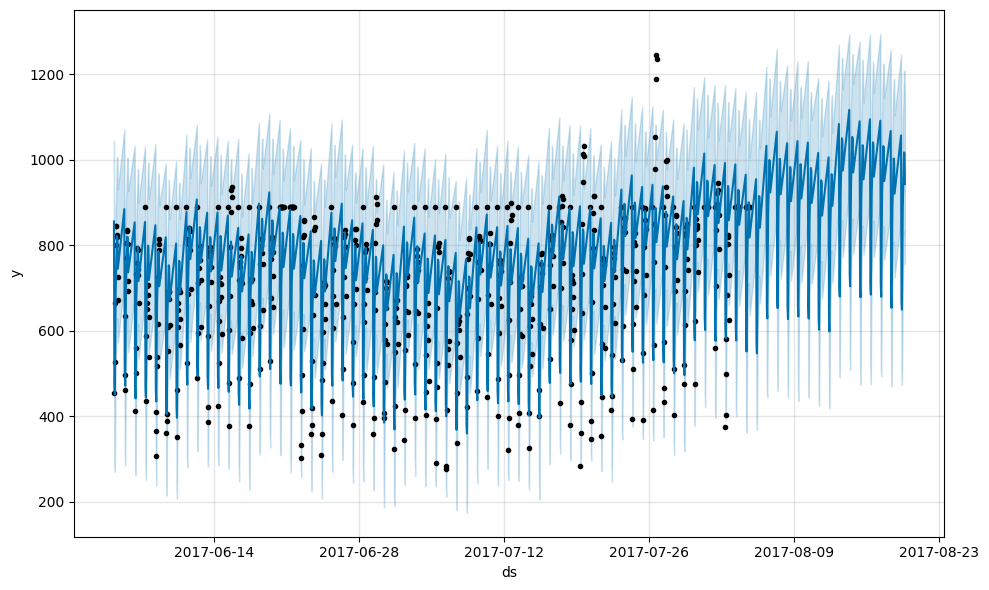

In [14]:
for i in grouped.groups.keys():
    df = pd.DataFrame()
    df["ds"] = final["ds"]
    df["yhat"] = final[f"yhat_{i}"]
    df["yhat_lower"]= final[f"yhat_lower_{i}"]
    df["yhat_upper"] = final[f"yhat_upper_{i}"]
    models[i].plot(df)

## Evaluate

### Split predicted value for test dataset

In [15]:
yhat = final.loc[final['ds'] >= forecast_start]

In [21]:
for i in range(len(models)):
    print(f"Municipality {i}")
    evaluate_forecast(test_df[i], yhat[f"yhat_{i}"])
    print("-------------")

Municipality 0
mae: 182.92452064141557
mse: 91467.06805773519
mape: 0.23047695843853389
-------------
Municipality 1
mae: 159.8043302589839
mse: 35816.97787659488
mape: 0.5617762407783768
-------------
Municipality 2
mae: 258.99864203643557
mse: 84689.41337676173
mape: 0.5706377537002176
-------------
Municipality 3
mae: 161.8143107356095
mse: 48711.735527911536
mape: 0.2007827673597572
-------------
Municipality 4
mae: 447.0729610611556
mse: 274623.30634232936
mape: 0.2212068642147191
-------------
Municipality 5
mae: 487.5234992450809
mse: 290592.2197546604
mape: 8.056092034726452
-------------
Municipality 6
mae: 209.2278101973995
mse: 76515.92444441734
mape: 0.19625513213008575
-------------
Municipality 7
mae: 124.88075009445888
mse: 26885.327522982956
mape: 0.11722983808586605
-------------
Municipality 8
mae: 153.81287803136308
mse: 43103.593473543006
mape: 0.1877785430321578
-------------
Municipality 9
mae: 151.74240853436623
mse: 41624.35722868213
mape: 0.2641969272606744
---

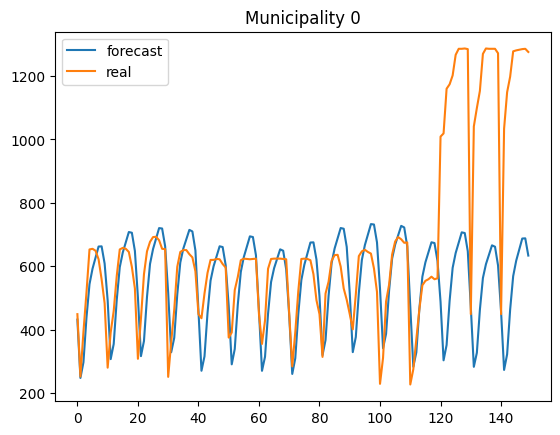

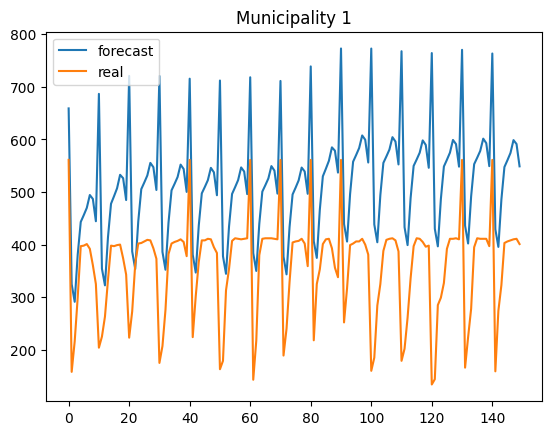

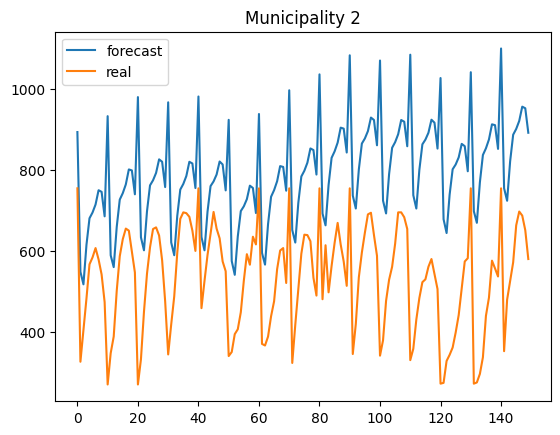

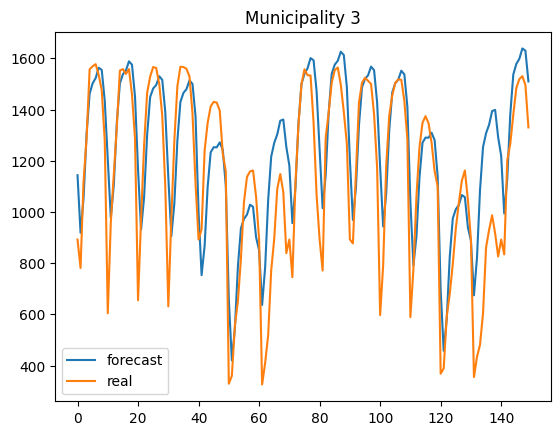

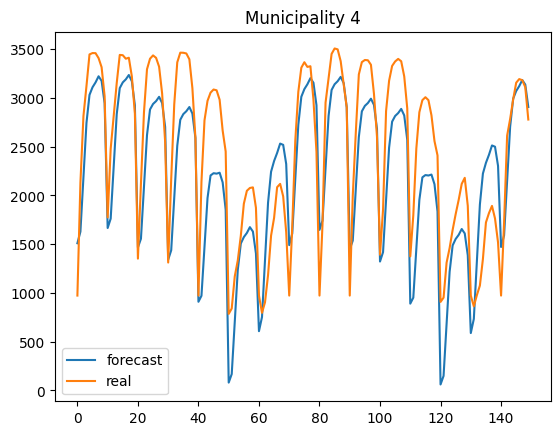

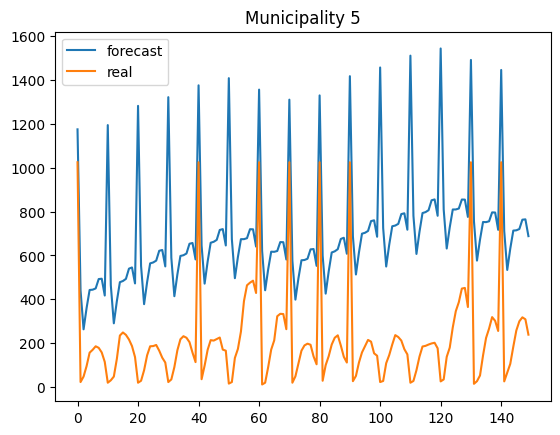

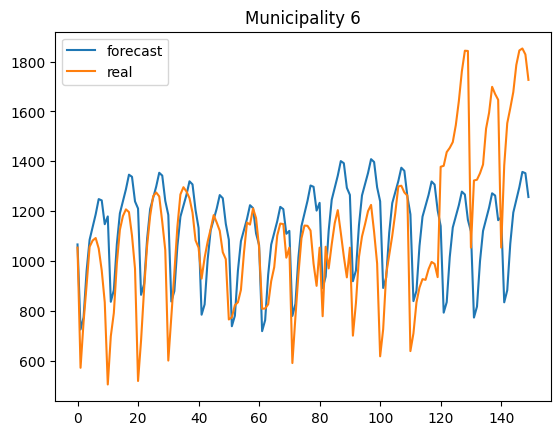

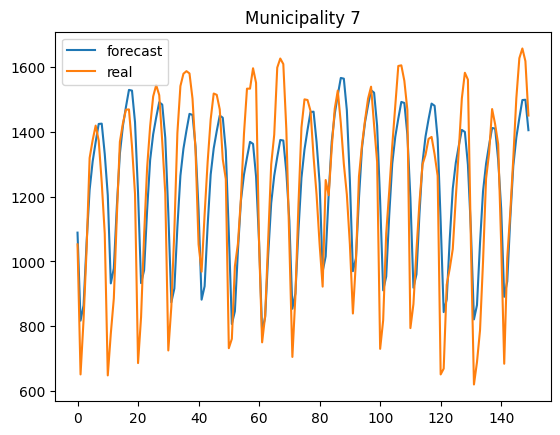

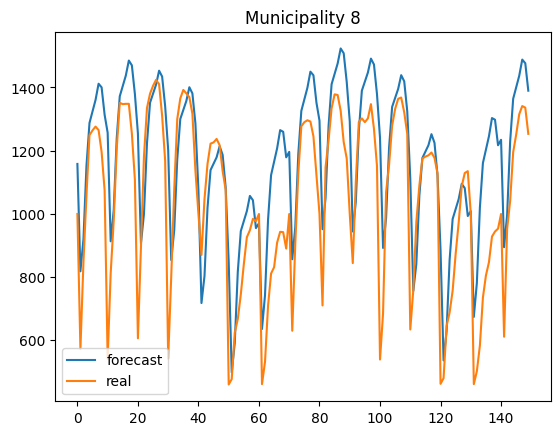

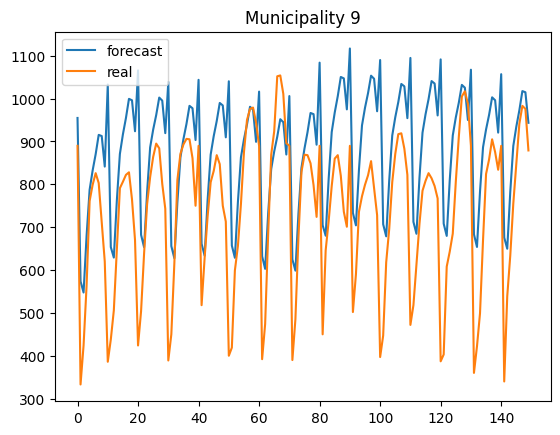

In [22]:
import matplotlib.pyplot as plt
for i in grouped.groups.keys():
    forecast = yhat[f"yhat_{i}"].values
    real = test_df[i].values
    plt.plot(forecast, label='forecast')
    plt.plot(real, label='real')
    plt.title(f'Municipality {i}')
    plt.legend()
    plt.show()